**Note**: This notebook has been adapted from the one [here](https://github.com/Featuretools/predict-customer-churn/blob/master/churn/3.%20Feature%20Engineering.ipynb) to remove any dependencies on AWS and S3 so as to just focus on the featuretools functionality without requireming you to make an AWS account and set up the `aws` cli. You should check out the full repo for some other cool notebooks and examples using Spark and Dask.

<a href="https://colab.research.google.com/github/springboard-curriculum/featuretools/blob/master/Feature%20Engineering.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment and run below to install required libraries if need to
#!pip install featuretools==0.4.0

# Introduction: Automated Feature Engineering with Featuretools

__Problem:__ we have a set of cutoff times and labels - in a label times table - and we need to build relevant features for each label using only data from before the cutoff time. Traditionally, we would do this by hand, a painstaking and error prone process that makes developing useable machine learning solutions extremely difficult. 

__Solution__: Use automated feature engineering as implemented in Featuretools to build hundreds or thousands of relevant features from a relational dataset with a reusable framework that also automatically filters the data based on the cutoff times. This approachs overcomes the limitations of manual feature engineering, letting us build better predictive models in a fraction of the time. 

The general process of feature engineering is shown below:

![](https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/images/feature_engineering_process.png)

Currently, the only option for automated feature engineering using multiple related tables is [Featuretools](https://github.com/Featuretools/featuretools), an open-source Python library. 

![](https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/images/featuretools-logo.png)

In this notebook, we'll work with Featuretools to develop an automated feature engineering workflow for the customer churn dataset. The end outcome is a function that takes in a dataset and label times for customers and builds a feature matrix that can be used to train a machine learning model. Because we already partitioned the data into independent subsets (in `Partitioning Data`) we'll be able to apply this function to all of the partitions in parallel using Spark with PySpark.

## Featuretools Resources

We won't spend too much time on the basics of Featuretools here, so refer to the following sources for more information:

* [Featuretools Documentation](https://docs.featuretools.com/)
* [Featuretools GitHub](https://github.com/Featuretools/featuretools)
* [Introductory tutorial on Featuretools](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)
* [Why Automated Feature Engineering Will Change Machine Learning](https://towardsdatascience.com/why-automated-feature-engineering-will-change-the-way-you-do-machine-learning-5c15bf188b96)

The basics are relatively easy to pick up, and if you're new, you can probably follow along with all the code here! Learning Featuretools requires only a few minutes and it can be applied to any relational dataset.


With that in mind, let's get started.

In [2]:
# Data science helpers
from pathlib import Path
import pandas as pd 
import numpy as np

import featuretools as ft

# Useful for showing multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# make some folders we will need if they do not exist
Path("./data/churn").mkdir(parents=True, exist_ok=True)

In [3]:
# Read in all data
members = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/members.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True, 
                      dtype = {'gender': 'category'})

trans = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], 
                    infer_datetime_format = True)

logs = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/logs.csv', parse_dates = ['date'])

cutoff_times = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/MS-31_labels.csv', parse_dates = ['cutoff_time'])

The 3 data tables are represented by the following schema. 

![image](https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/images/data_schema.png)

This schema is all the domain knowledge needed to perform automated feature engineering in Featuretools.

In [4]:
# Visualize the data
print('Members:\n')
members.info()
print('Transactions:\n')
trans.info()
print('Logs:\n')
logs.info()
print('cutoff_times:\n')
cutoff_times.info()

Members:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    6658 non-null   object        
 1   city                    6658 non-null   int64         
 2   bd                      6658 non-null   int64         
 3   gender                  2337 non-null   category      
 4   registered_via          6658 non-null   int64         
 5   registration_init_time  6658 non-null   datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(3), object(1)
memory usage: 266.8+ KB
Transactions:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22940 entries, 0 to 22939
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    22940 non-null  object        
 1   payment_meth

# Define Entities and EntitySet

The first step in using Featuretools is to make an `EntitySet` and add all the `entitys` - tables - to it. An EntitySet is a data structure that holds the tables and the relationships between them. This makes it easier to keep track of all the data in a problem with multiple relational tables.

In [5]:
import featuretools.variable_types as vtypes

# Make empty entityset
es = ft.EntitySet(id = 'customers')

In [6]:
print(es)

Entityset: customers
  Entities:
  Relationships:
    No relationships


## Entities

When creating entities from a dataframe, we need to make sure to include:

* The `index` if there is one or a name for the created index. This is a unique identifier for each observation.
* `make_index = True` if there is no index, we need to supply a name under `index` and set this to `True`.
* A `time_index` if present. This is the time at which the information in the row becomes known. Featuretools will use the `time_index` and the `cutoff_time` to make valid features for each label.
* `variable_types`. In some cases our data will have variables for which we should specify the type. An example would be a boolean that is represented as a float. This prevents Featuretools from making features such as the `min` or `max` of a True/False varaibles.

For this problem these are the only arguments we'll need. There are additional arguments that can be used as shown in [the documentation](https://docs.featuretools.com/api_reference.html#entityset-entity-relationship-variable-types). 

### Members Table

The `members` table holds basic information about each customer. The important point for this table is to specify that the `city` and `registered_via` columns are discrete, categorical variables and not numerical and that `registration_init_time` is the `time_index`. The `msno` is the unique index identifying each customer. 

In [7]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,NaN,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


In [8]:
members['msno'].is_unique

True

In [9]:
# Create entity from members
es.entity_from_dataframe(entity_id='members', dataframe=members,
                         index = 'msno', time_index = 'registration_init_time', 
                         variable_types = {'city': vtypes.Categorical, 
                                           'registered_via': vtypes.Categorical})

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
  Relationships:
    No relationships

### Transactions Table

The transactions table contains payments made by the customers. Each row records one payment. 

In [10]:
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0


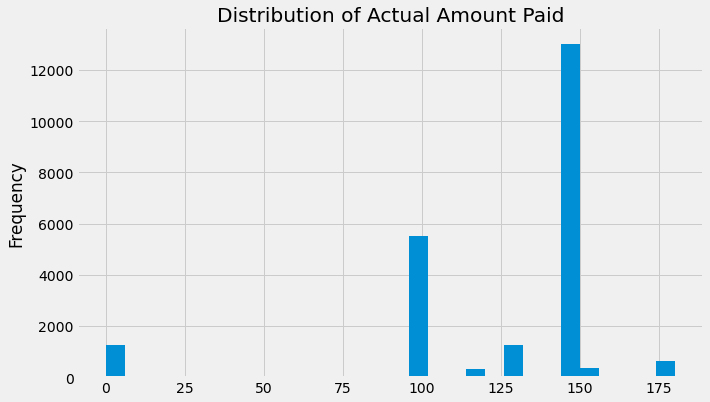

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

trans.loc[trans['actual_amount_paid'] < 250, 'actual_amount_paid'].dropna().plot.hist(bins = 30);
plt.title('Distribution of Actual Amount Paid');

#### Domain Knowledge Features

Before creating the entity from this dataframe, we can create a few new variables based on domain knowledge. Just because we are automatically going to make hundreds of features doesn't mean we can't use our own expertise. Featuretools will build on top of our knowledge by stacking more primitives on top of any variables that we define.

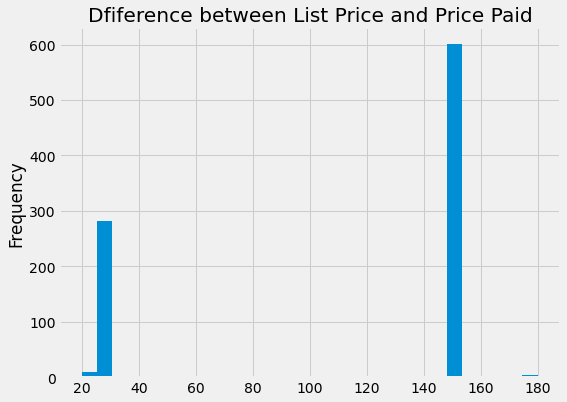

In [12]:
# Difference between listing price and price paid
trans['price_difference'] = trans['plan_list_price'] - trans['actual_amount_paid']

# Planned price per day
trans['planned_daily_price'] = trans['plan_list_price'] / trans['payment_plan_days']

# Actual price per day
trans['daily_price'] = trans['actual_amount_paid'] / trans['payment_plan_days']

trans.loc[trans['price_difference'] > 0, 'price_difference'].plot.hist(bins = 30, 
                                                                       figsize = (8, 6));
plt.title('Dfiference between List Price and Price Paid');

There is no `index` in this dataframe so we have to specify to make an index and pass in a name. There is a `time_index`, the time of the transaction, which will be critical when filtering data based on cutoff times to make features. Again, we also need to specify several variable types.

There is one slight anomaly with the transactions where some membership expire dates are after the transactions date, so we will filter those out.

In [13]:
# Filter anomalies
trans = trans[trans['membership_expire_date'] > trans['transaction_date']]

In [14]:
trans.head(5)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,price_difference,planned_daily_price,daily_price
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0,0,3.300000,3.300000
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0,0,4.966667,4.966667
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0,0,4.966667,4.966667
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0,30,4.966667,3.966667
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0,0,4.966667,4.966667


In [15]:
# Create entity from transactions
es.entity_from_dataframe(entity_id='transactions', dataframe=trans,
                         index = 'transactions_index', make_index = True,
                         time_index = 'transaction_date', 
                         variable_types = {'payment_method_id': vtypes.Categorical, 
                                           'is_auto_renew': vtypes.Boolean, 'is_cancel': vtypes.Boolean})

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
    transactions [Rows: 22329, Columns: 13]
  Relationships:
    No relationships

### Logs

The `logs` contain user listening behavior. As before we'll make a few domain knowledge columns before adding to the `EntitySet`. 

In [16]:
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,6+/V1NwBbqjBOCvRSDueeJZ58F4DY7h7fG6fSZtHaAE=,2017-03-04,29,28,18,11,111,79,34727.142
1,E2aBGFTKR6jzp+1knh7JOOF39gLuu+CoZMWaAL/DA0M=,2017-03-27,1,0,2,0,184,173,33408.719
2,g7exJzakJlHXwzUydnShY5w24WXSwJyS6QqgoFeyr7g=,2017-03-15,0,0,0,0,21,21,4951.000
3,X+i9OmM3P42cETt5gPkOnz8vXGViQL5/M/NMiMQ+Olc=,2017-03-13,3,1,0,0,33,27,8755.599
4,tbl8blAVl6j4A8zW1Gnyg78Hc0LAQzzcYesmzgJ7ofs=,2017-03-27,6,5,0,0,2,6,1035.853


In [17]:
# Make a few features by hand
logs['total'] = logs[['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum(axis = 1)
logs['percent_100'] = logs['num_100'] / logs['total']
logs['percent_unique'] = logs['num_unq'] / logs['total']
logs['seconds_per_song'] = logs['total_secs'] / logs['total'] 

logs.head(5)

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total,percent_100,percent_unique,seconds_per_song
0,6+/V1NwBbqjBOCvRSDueeJZ58F4DY7h7fG6fSZtHaAE=,2017-03-04,29,28,18,11,111,79,34727.142,197,0.563452,0.401015,176.279909
1,E2aBGFTKR6jzp+1knh7JOOF39gLuu+CoZMWaAL/DA0M=,2017-03-27,1,0,2,0,184,173,33408.719,187,0.983957,0.925134,178.656251
2,g7exJzakJlHXwzUydnShY5w24WXSwJyS6QqgoFeyr7g=,2017-03-15,0,0,0,0,21,21,4951.000,21,1.000000,1.000000,235.761905
3,X+i9OmM3P42cETt5gPkOnz8vXGViQL5/M/NMiMQ+Olc=,2017-03-13,3,1,0,0,33,27,8755.599,37,0.891892,0.729730,236.637811
4,tbl8blAVl6j4A8zW1Gnyg78Hc0LAQzzcYesmzgJ7ofs=,2017-03-27,6,5,0,0,2,6,1035.853,13,0.153846,0.461538,79.681000


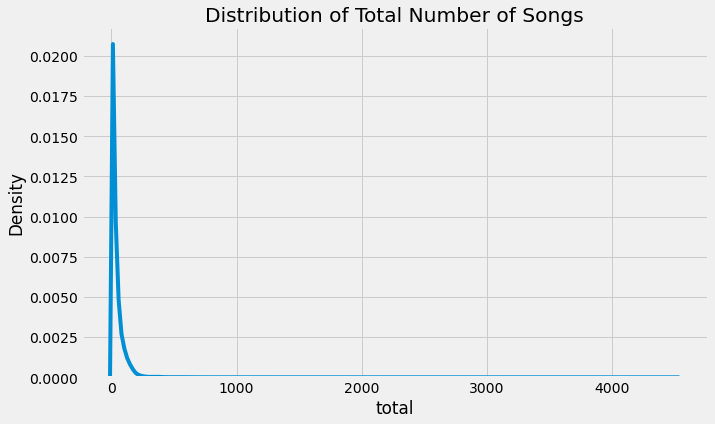

In [18]:
import seaborn as sns

sns.kdeplot(logs['total']);
plt.title('Distribution of Total Number of Songs');

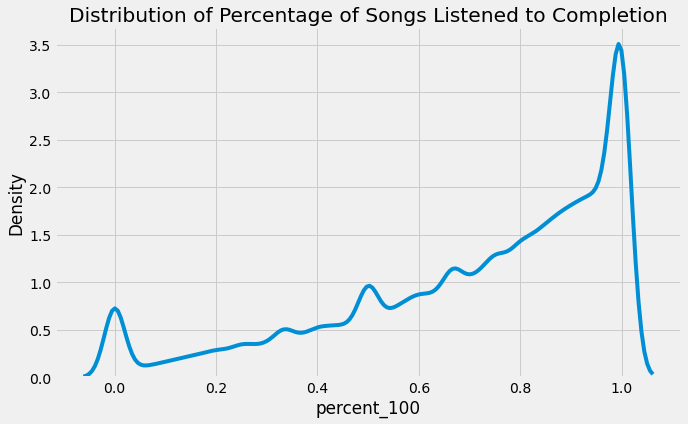

In [19]:
sns.kdeplot(logs['percent_100']);
plt.title('Distribution of Percentage of Songs Listened to Completion');

There is `time_index` in the logs although no `index` present.

In [20]:
es.entity_from_dataframe(entity_id='logs', dataframe=logs,
                         index = 'logs_index', make_index = True,
                         time_index = 'date')

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
    transactions [Rows: 22329, Columns: 13]
    logs [Rows: 424252, Columns: 14]
  Relationships:
    No relationships

Making features by hand may seem counterintuitive if we are using automated feature engineering, but the benefits of doing this before using Featuretools is that these features can be stacked on top of to build deep features. Automated feature engineering will therefore take our existing hand-built features and extract more value from them by combining them with other features.

Another method to improve the power of deep feature synthesis is through interesting values, which specify conditional statements used to build features.

### Interesting Values

In order to create conditional features, we can set interesting values for existing columns in the data. The following code will be used to build features conditional on the value of `is_cancel` and `is_auto_renew` in the transactions data. The primitives used for the conditional features are specified as `where_primitives` in the call to Deep Feature Synthesis. For example, if we used a `mean` primitive along with the following interesting values, we will get a mean of transactions where the transaction was cancelled, as well as the mean of transactions where the transaction was not cancelled. 

In [24]:
es['transactions']

Entity: transactions
  Variables:
    transactions_index (dtype: index)
    msno (dtype: categorical)
    payment_plan_days (dtype: numeric)
    plan_list_price (dtype: numeric)
    actual_amount_paid (dtype: numeric)
    transaction_date (dtype: datetime_time_index)
    membership_expire_date (dtype: datetime)
    price_difference (dtype: numeric)
    planned_daily_price (dtype: numeric)
    daily_price (dtype: numeric)
    payment_method_id (dtype: categorical)
    is_auto_renew (dtype: boolean)
    is_cancel (dtype: boolean)
  Shape:
    (Rows: 22329, Columns: 13)

In [25]:
es['transactions']['is_cancel']

<Variable: is_cancel (dtype = boolean)>

In [26]:
es['transactions']['is_cancel'].interesting_values = [0, 1]
es['transactions']['is_auto_renew'].interesting_values = [0, 1]

# Relationships

Table relationships should be familiar to anyone who has worked with relational databases and the idea is the same in Featuretools. We use relationships to specify how examples in one table relate to examples in other tables. The entityset structure for this problem is fairly simple as there are only three entities with two relationships.  `members` is the parent of `logs` and `transactions`. In both relationships, the parent and child variable is `msno`, the customer id.

The two relationships are: one linking `members` to `transactions` and one linking `members` to `logs`. The order for relationships in featuretools is parent variable, child variable.

In [29]:
# Relationships (parent, child)
r_member_transactions = ft.Relationship(es['members']['msno'], es['transactions']['msno'])
r_member_logs = ft.Relationship(es['members']['msno'], es['logs']['msno'])

es.add_relationships([r_member_transactions, r_member_logs])

Entityset: customers
  Entities:
    members [Rows: 6658, Columns: 6]
    transactions [Rows: 22329, Columns: 13]
    logs [Rows: 424252, Columns: 14]
  Relationships:
    transactions.msno -> members.msno
    logs.msno -> members.msno

### Cutoff Times

`cutoff_times` are a critical piece of any time based machine learning problem. The label times dataframe has columns of member id, cutoff time, and label. __For each cutoff time, only data from before the cutoff time can be used to build features for that label.__ This is one of the greatest advantages of Featuretools compared to manual feature engineering: __Featuretools automatically filters our data based on the cutoff times to ensure that all the features are valid for machine learning.__ Normally, we would have to take extreme care to make sure all of our features are valid, but Featreutools is able to implement the filtering logic behind the scenes for us.

All we have to do is make sure to pass in the correct label times for the prediction problem we want to solve.

In [30]:
cutoff_times = cutoff_times.drop_duplicates(subset = ['msno', 'cutoff_time'])
cutoff_times.head()

,msno,cutoff_time,label,days_to_churn,churn_date
0,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-08-01,0.0,NaN,NaN
1,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-09-01,0.0,NaN,NaN
2,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-10-01,0.0,NaN,NaN
3,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-11-01,0.0,NaN,NaN
4,++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,2015-12-01,0.0,NaN,NaN


# Deep Feature Synthesis

With the entities and relationships fully defined, we are ready to run [Deep Feature Synthesis (DFS)](https://www.featurelabs.com/blog/deep-feature-synthesis/). This process applies feature engineering building blocks called [feature primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html) to a dataset to build hundreds of features. Feature primitives are basic operations of two types - transforms and aggregations - that stack to build deep features (for more information see the previous linked resources). These includes many operations that we would traditionally carry out by hand, but automated feature engineering saves us from having to implement these features one at a time. 

The call to `ft.dfs` needs the entityset which holds all the tables and relationships between them, the `target_entity` to make features for, the specific primitives, the maximum stacking of primitives (`max_depth`), the `cutoff_times`, and a number of optional parameters.

To start, we'll use the default aggregation and transformation primitives as well as two `where_primitives` and see how many features this generates. To only generate the definitions of the features, we pass in `features_only = True`.

For full details on Deep Feature Synthesis, take a look at [the documentation](https://docs.featuretools.com/api_reference.html#deep-feature-synthesis). 

In [31]:
feature_defs = ft.dfs(entityset=es, target_entity='members', 
                      cutoff_time = cutoff_times,
                      where_primitives = ['sum', 'mean'],
                      max_depth=2, features_only=True)

In [32]:
feature_defs

[<Feature: bd>,
 <Feature: gender>,
 <Feature: city>,
 <Feature: registered_via>,
 <Feature: COUNT(transactions)>,
 <Feature: MAX(transactions.actual_amount_paid)>,
 <Feature: MAX(transactions.daily_price)>,
 <Feature: MAX(transactions.payment_plan_days)>,
 <Feature: MAX(transactions.plan_list_price)>,
 <Feature: MAX(transactions.planned_daily_price)>,
 <Feature: MAX(transactions.price_difference)>,
 <Feature: MEAN(transactions.actual_amount_paid)>,
 <Feature: MEAN(transactions.daily_price)>,
 <Feature: MEAN(transactions.payment_plan_days)>,
 <Feature: MEAN(transactions.plan_list_price)>,
 <Feature: MEAN(transactions.planned_daily_price)>,
 <Feature: MEAN(transactions.price_difference)>,
 <Feature: MIN(transactions.actual_amount_paid)>,
 <Feature: MIN(transactions.daily_price)>,
 <Feature: MIN(transactions.payment_plan_days)>,
 <Feature: MIN(transactions.plan_list_price)>,
 <Feature: MIN(transactions.planned_daily_price)>,
 <Feature: MIN(transactions.price_difference)>,
 <Feature: MODE

In [33]:
print(f'This will generate {len(feature_defs)} features.')

This will generate 188 features.


In [34]:
import random; random.seed(42)

random.sample(feature_defs, 10)

[<Feature: SUM(transactions.daily_price WHERE is_cancel = 0)>,
 <Feature: SKEW(transactions.daily_price)>,
 <Feature: MAX(transactions.daily_price)>,
 <Feature: MIN(logs.num_50)>,
 <Feature: MEAN(logs.num_unq)>,
 <Feature: MEAN(logs.num_100)>,
 <Feature: STD(transactions.payment_plan_days)>,
 <Feature: PERCENT_TRUE(transactions.is_cancel)>,
 <Feature: SUM(transactions.planned_daily_price WHERE is_cancel = 1)>,
 <Feature: MEAN(transactions.price_difference WHERE is_cancel = 0)>]

We can see that Featuretools has built almost 200 features automatically for us using the table relationships and feature primitives. If built by hand, each of these features would require minutes of work, totaling many hours to build 188 features. Moreover, although the features are not necessarily intuitive, they are easy to explain in natural language because they are simple operations stacked on top of each other.

## Specify Primitives 

Now we'll do a call to `ft.dfs` specifying the primitives to use. Often, these will depend on the problem and can involve domain knowledge. The best way to choose primitives is by trying out a variety and seeing which perform the best. Like many operations in machine learning, choosing primitives is still largely an empirical, rather than theoretical, practice.

### Aggregation Primitives

In [23]:
all_p = ft.list_primitives()
trans_p = all_p.loc[all_p['type'] == 'transform'].copy()
agg_p = all_p.loc[all_p['type'] == 'aggregation'].copy()

pd.options.display.max_colwidth = 100
agg_p.head()

,name,type,description
0,skew,aggregation,Computes the skewness of a data set.
1,avg_time_between,aggregation,Computes the average time between consecutive events.
2,max,aggregation,Finds the maximum non-null value of a numeric feature.
3,percent_true,aggregation,Finds the percent of 'True' values in a boolean feature.
4,mode,aggregation,Finds the most common element in a categorical feature.


In [24]:
# Specify aggregation primitives
agg_primitives = ['sum', 'time_since_last', 'avg_time_between', 'all', 'mode', 'num_unique', 'min', 'last', 
                  'mean', 'percent_true', 'max', 'std', 'count']

## Transform Primitives

In [25]:
trans_p.tail()

,name,type,description
57,multiply,transform,Creates a transform feature that multplies two features.
58,days,transform,Transform a Timedelta feature into the number of days.
59,time_since_previous,transform,Compute the time since the previous instance.
60,subtract,transform,Creates a transform feature that subtracts two features.
61,not,transform,"For each value of the base feature, negates the boolean value."


In [26]:
# Specify transformation primitives
trans_primitives = ['weekend', 'cum_sum', 'day', 'month', 'diff', 'time_since_previous']

### Where Primitives

These primitives are applied to the `interesting_values` to build conditional features. 

In [27]:
# Specify where primitives
where_primitives = ['sum', 'mean', 'percent_true', 'all', 'any']

## Custom Primitives

[Custom primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html#defining-custom-primitives) are one of the most powerful options in Featuretools. We use custom primitives to write our own functions based on domain knowledge and then pass them to `dfs` like any other primitives. Featuretools will then stack our custom primitives with the other primitives, again, in effect, amplifying our domain knowledge.

For this problem, I wrote a custom primitive that calculates the sum of a value in the month prior to the cutoff time. This is actually a primitive I [wrote for another problem](https://github.com/Featuretools/Automated-Manual-Comparison/tree/master/Retail%20Spending) but I can apply it to this problem because primitives are data agnostic. That's one of the benefits of feature primitives: they can work for any problem and writing a custom primitive will pay off many times over.

In [28]:
from featuretools.primitives import make_agg_primitive

def total_previous_month(numeric, datetime, time):
    """Return total of `numeric` column in the month prior to `time`."""
    df = pd.DataFrame({'value': numeric, 'date': datetime})
    previous_month = time.month - 1
    year = time.year
   
    # Handle January
    if previous_month == 0:
        previous_month = 12
        year = time.year - 1
        
    # Filter data and sum up total
    df = df[(df['date'].dt.month == previous_month) & (df['date'].dt.year == year)]
    total = df['value'].sum()
    
    return total

In [29]:
numeric = [10, 12, 14, 15, 19, 22, 9, 8, 8, 11]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(numeric))
pd.DataFrame({'value': numeric, 'date': dates}).head(6)
total_previous_month(numeric, dates, pd.datetime(2018, 2, 1))

,value,date
0,10,2018-01-01 00:00:00
1,12,2018-01-07 13:20:00
2,14,2018-01-14 02:40:00
3,15,2018-01-20 16:00:00
4,19,2018-01-27 05:20:00
5,22,2018-02-02 18:40:00


C:\Users\andre\AppData\Local\Temp/ipykernel_20588/2954234410.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  total_previous_month(numeric, dates, pd.datetime(2018, 2, 1))


70

In [30]:
numeric = [10, 12, 14, 5, 7, 8]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(numeric))
pd.DataFrame({'value': numeric, 'date': dates}).head(6)
total_previous_month(numeric, dates, pd.datetime(2018, 3, 1))

,value,date
0,10,2018-01-01 00:00:00
1,12,2018-01-12 19:12:00
2,14,2018-01-24 14:24:00
3,5,2018-02-05 09:36:00
4,7,2018-02-17 04:48:00
5,8,2018-03-01 00:00:00


C:\Users\andre\AppData\Local\Temp/ipykernel_20588/4109820222.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  total_previous_month(numeric, dates, pd.datetime(2018, 3, 1))


12

### Custom Primitive Implementation

Making a custom primitive is simple: first we define a function (`total_previous_month`) and then we `make_agg_primitive` with `input_type[s]`, a `return_type`, and whether or not the primitive requires the `cutoff_time` through `uses_calc_time`. 

This primitive is an aggregation primitive because it takes in multiple numbers - transactions for the previous month - and returns a single number - the total of the transactions. 

In [31]:
# Takes in a number and outputs a number
total_previous = make_agg_primitive(total_previous_month, input_types = [ft.variable_types.Numeric,
                                                                         ft.variable_types.Datetime],
                                    return_type = ft.variable_types.Numeric, 
                                    uses_calc_time = True)

Now just have to pass this in as another aggregation primitive for Featuretools to use it in calculations.


The second custom primitive finds the time since a previous true value. This is originally intended for the `is_cancel` variable in the `transactions` dataframe, but it can work for any Boolean variable. It simply finds the time between True examples.

In [32]:
def time_since_true(boolean, datetime):
    """Calculate time since previous true value"""
    
    if np.any(np.array(list(boolean)) == 1):
        # Create dataframe sorted from oldest to newest 
        df = pd.DataFrame({'value': boolean, 'date': datetime}).\
                sort_values('date', ascending = False).reset_index()

        older_date = None

        # Iterate through each date in reverse order
        for date in df.loc[df['value'] == 1, 'date']:

            # If there was no older true value
            if older_date == None:
                # Subset to times on or after true
                times_after_idx = df.loc[df['date'] >= date].index

            else:
                # Subset to times on or after true but before previous true
                times_after_idx = df.loc[(df['date'] >= date) & (df['date'] < older_date)].index
            older_date = date
            # Calculate time since previous true
            df.loc[times_after_idx, 'time_since_previous'] = (df.loc[times_after_idx, 'date'] - date).dt.total_seconds()

        return list(df['time_since_previous'])[::-1]
    
    # Handle case with no true values
    else:
        return [np.nan for _ in range(len(boolean))]

In [33]:
booleans = []
dates = []
df = pd.DataFrame({'value': booleans, 'date': dates})
time_since_true(df['value'], df['date'])

[]

In [34]:
booleans = [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(booleans))
df = pd.DataFrame({'value': booleans, 'date': dates})
time_since_true(df['value'], df['date'])

[0.0,
 509760.00000000006,
 1019520.0000000001,
 1529280.0,
 2039040.0000000002,
 0.0,
 0.0,
 0.0,
 509760.00000000006,
 1019520.0000000001,
 1529280.0]

In [35]:
booleans = [1, 0, 0]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(booleans))
time_since_true(booleans, dates)

[0.0, 2548800.0, 5097600.0]

In [36]:
booleans = [0, 0]
dates = pd.date_range('2018-01-01', '2018-03-01', periods = len(booleans))
time_since_true(booleans, dates)

[nan, nan]

This is a transformation primitive since it acts on multiple columns in the same table. The returned list is the same length as the original column.

In [37]:
from featuretools.primitives import make_trans_primitive

# Specify the inputs and return
time_since = make_trans_primitive(time_since_true, 
                                  input_types = [vtypes.Boolean, vtypes.Datetime],
                                  return_type = vtypes.Numeric)

Let's add the two custom primitives to the respective lists. In the final version of feature engineering, I did not use the `time_since` primitive. I ran into problems with the implementation but would encourage anyone to try and fix it or build their own custom primitive[s].

In [38]:
agg_primitives.append(total_previous)
# trans_primitives.append(time_since)

## Deep Feature Synthesis with Specified Primitives

We'll again run Deep Feature Synthesis to make the feature definitions this time using the selected primitives and the custom primitives. 

In [39]:
feature_defs = ft.dfs(entityset=es, target_entity='members', 
                      cutoff_time = cutoff_times, 
                      agg_primitives = agg_primitives,
                      trans_primitives = trans_primitives,
                      where_primitives = where_primitives,
                      chunk_size = len(cutoff_times), 
                      cutoff_time_in_index = True,
                      max_depth = 2, features_only = True)

In [40]:
print(f'This will generate {len(feature_defs)} features.')

This will generate 255 features.


In [41]:
random.sample(feature_defs, 15)

[<Feature: LAST(transactions.payment_plan_days)>,
 <Feature: SUM(transactions.plan_list_price WHERE is_cancel = 1)>,
 <Feature: MEAN(logs.percent_unique)>,
 <Feature: SUM(transactions.planned_daily_price)>,
 <Feature: SUM(transactions.price_difference)>,
 <Feature: LAST(transactions.plan_list_price)>,
 <Feature: TOTAL_PREVIOUS_MONTH(transactions.plan_list_price, membership_expire_date)>,
 <Feature: TOTAL_PREVIOUS_MONTH(transactions.plan_list_price, transaction_date)>,
 <Feature: STD(logs.percent_100)>,
 <Feature: SUM(transactions.plan_list_price WHERE is_auto_renew = 0)>,
 <Feature: SUM(transactions.actual_amount_paid)>,
 <Feature: TOTAL_PREVIOUS_MONTH(logs.total, date)>,
 <Feature: STD(transactions.daily_price)>,
 <Feature: ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 0)>,
 <Feature: SUM(transactions.planned_daily_price WHERE is_auto_renew = 0)>]

We can see that our custom primitive `TOTAL_PREVIOUS_MONTH` has been applied to create more features. The benefit of custom primitives are that they can be used to encode specific domain knowledge into the feature engineering process. Moreover, we don't get just the custom primitive itself, we also get features that are stacked on top of the primitive.

# Run Deep Feature Synthesis

Once we're happy with the features that will be generated, we can run deep feature synthesis to make the actual features. We need to change `feature_only` to `False` and then we're good to go.

In [42]:
from timeit import default_timer as timer

start = timer()
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='members', 
                                      cutoff_time = cutoff_times, 
                                      agg_primitives = agg_primitives,
                                      trans_primitives = trans_primitives,
                                      where_primitives = where_primitives,
                                      max_depth = 1, features_only = False,
                                      verbose = 1, chunk_size = 100,  
                                      n_jobs = 1,
                                      cutoff_time_in_index = True)
end = timer()
print(f'{round(end - start)} seconds elapsed.')

Built 203 features
Elapsed: 29:20 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 273/273 chunks
1762 seconds elapsed.


The `chunk_size` is a parameter that may need to be adjusted to optimize the calculation. I suggest playing around with this parameter to find the optimal value. Generally I've found that a large value makes the calculation proceed quicker although it depends on the machine in use and the number of unique cutoff times. 

In [43]:
feature_matrix.head()

,,bd,city,registered_via,gender,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.price_difference),SUM(transactions.planned_daily_price),SUM(transactions.daily_price),...,MEAN(transactions.daily_price WHERE is_auto_renew = 1),MEAN(transactions.daily_price WHERE is_cancel = 0),MEAN(transactions.daily_price WHERE is_auto_renew = 0),PERCENT_TRUE(transactions.is_auto_renew WHERE is_cancel = 1),PERCENT_TRUE(transactions.is_auto_renew WHERE is_cancel = 0),PERCENT_TRUE(transactions.is_cancel WHERE is_auto_renew = 1),PERCENT_TRUE(transactions.is_cancel WHERE is_auto_renew = 0),label,days_to_churn,churn_date
msno,time,,,,,,,,,,,,,,,,,,,,,
+9v4Rbyc+58MyKbt1wrCskWClJadOJh7CapZa9CYXUM=,2015-01-01,24.0,5.0,7.0,female,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
+FMjiiorqZQ3ZzNNmgO0vZM2yh8IHPvWSvwy2fSBMLU=,2015-01-01,27.0,6.0,7.0,male,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
+V3HOZsK34UPrNOYg6IhG8sP1dY6w5LG8J98eodnBBk=,2015-01-01,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
+ikgRAmrCW349x39kQ0nOqh9jvajPXJFZkI9Q6omEMs=,2015-01-01,0.0,14.0,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,464.0,NaN
+kbXNszLheADYStfNoRwa9q9sZykS5Tfk044GMwOw1o=,2015-01-01,29.0,15.0,9.0,male,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN


We can save these feature definitions as a binary file which will allow us to make the same exact features for another entityset of the same format. This is useful when we have multiple partitions and we want to make the same features for each. Instead of remaking the feature definitions, we pass in the same feature definitions to a call to `calculate_feature_matrix`.

In [44]:
ft.save_features(feature_defs, './data/churn/features.txt')

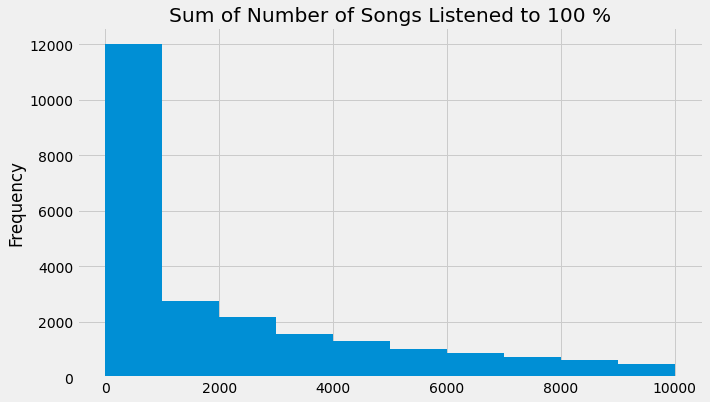

In [45]:
feature_matrix.loc[feature_matrix['SUM(logs.num_100)'] < 10000, 'SUM(logs.num_100)'].plot.hist();
plt.title('Sum of Number of Songs Listened to 100 %');

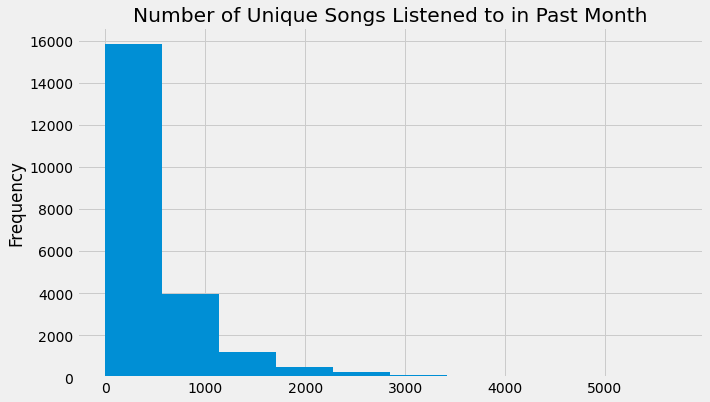

In [46]:
feature_matrix['TOTAL_PREVIOUS_MONTH(logs.num_unq, date)'].plot.hist()
plt.title('Number of Unique Songs Listened to in Past Month');

In [47]:
feature_matrix['TOTAL_PREVIOUS_MONTH(logs.num_unq, date)'].describe()

count    21944.000000
mean       452.605359
std        561.207982
min          0.000000
25%         61.000000
50%        276.000000
75%        626.000000
max       5697.000000
Name: TOTAL_PREVIOUS_MONTH(logs.num_unq, date), dtype: float64

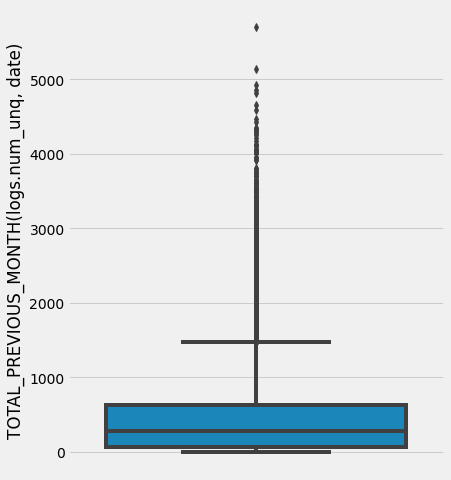

In [48]:
plt.figure(figsize = (6, 8))
sns.boxplot(y = feature_matrix['TOTAL_PREVIOUS_MONTH(logs.num_unq, date)']);

In [49]:
feature_defs = ft.load_features('./data/churn/features.txt')
print(f'There are {len(feature_defs)} features.')

There are 203 features.


# Conclusions

Automated feature engineering is a significant improvement over manual feature engineering in terms of both time and modeling performance. In this notebook, we implemented an automated feature engineering workflow with Featuretools for the customer churn problem. Given customer data and label times, we can now calculate a feature matrix with several hundred relevant features for predicting customer churn while ensuring that our features are made with valid data for each cutoff time. 

Along the way, we implemented a number of Featuretools concepts:

1. An entityset and entities
2. Relationships between entities
3. Cutoff times
4. Feature primitives
5. Custom primitives
6. Deep feature synthesis

These concepts will serve us well in future machine learning projects that we can tackle with automated feature engineering.

## Next Steps

Although we often hear that "data is the fuel of machine learning", data is not exactly a fuel but more like crude oil. _Features_ are the refined product that we feed into a machine learning model to make accurate predictions. After performing prediction engineering and automated feature engineering, the next step is to use these features in a predictive model to estimate the _label_ using the _features_. 

Generating hundreds of features automatically is impressive, but if those features cannot allow a model to learn our prediction problem then they are not mcuch help! The next step is to use our features and labeled historical examples to train a machine learning model to make predictions of customer churn. We'll make sure to test our model using a hold-out testing set to estimate performance on new data. Then, after validating our model, we can use it on new examples by passing the data through the feature engineering process. 


If you want to see how to parallelize feature engineering in Spark, see the `Feature Engineering on Spark` notebook. Otherwise, the next notebook is `Modeling`, where we develop a machine learning model to predict churn using the historical labeled examples and the automatically engineered features.